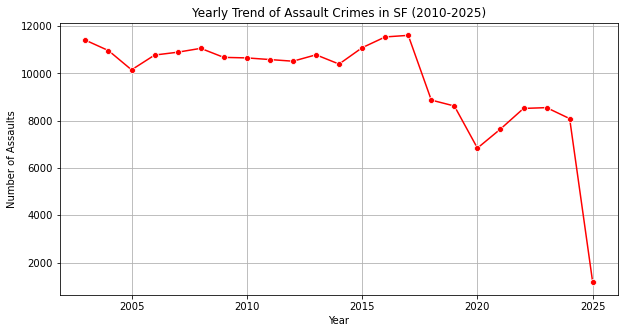

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_file

# Load Data
df = pd.read_csv('merged_data.csv')

# Filter for Assault Crimes
df_assault = df[df['Category'] == 'ASSAULT']

# --- 1. Time-Series Plot: Yearly Trend of Assault Crimes ---
plt.figure(figsize=(10, 5))
assault_trend = df_assault.groupby('Year').size()
sns.lineplot(x=assault_trend.index, y=assault_trend.values, marker="o", color="red")
plt.title("Yearly Trend of Assault Crimes in SF (2010-2025)")
plt.xlabel("Year")
plt.ylabel("Number of Assaults")
plt.grid()
plt.show()

In [14]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Load Data
df = pd.read_csv('merged_data.csv')

# Filter for Assault Crimes
df_assault = df[df['Category'] == 'ASSAULT']

# Drop rows with missing coordinates
df_assault = df_assault.dropna(subset=['Latitude', 'Longitude'])

# Initialize Folium Map Centered Around SF
sf_map = folium.Map(location=[37.77, -122.42], zoom_start=12)

# Create HeatMap Data (Limit Points for Performance)
heat_data = list(zip(df_assault['Latitude'], df_assault['Longitude']))
HeatMap(heat_data[:5000], radius=10, blur=15, max_zoom=1).add_to(sf_map)  # Limiting to 5000 points for speed

# Save and Show Map
sf_map.save("sf_assault_heatmap.html")
print("Heatmap saved as 'sf_assault_heatmap.html'. Open it in your browser.")

Heatmap saved as 'sf_assault_heatmap.html'. Open it in your browser.


In [2]:
import pandas as pd
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.io import output_notebook

# Load Data
df = pd.read_csv("merged_data.csv")

# Rename 'DayOfMonth' to 'Day' if needed
if 'DayOfMonth' in df.columns:
    df.rename(columns={'DayOfMonth': 'Day'}, inplace=True)

# Ensure 'Day' exists and fill missing values with 1
if 'Day' not in df.columns or df['Day'].isnull().any():
    df['Day'] = 1

# Convert 'Month' (string) to numerical values
month_mapping = {month: index for index, month in enumerate([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"], start=1)}
df['Month'] = df['Month'].map(month_mapping)

# Convert to datetime format
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Filter for Assault Cases
df_assault = df[df['Category'] == 'ASSAULT']

# Aggregate by Day (Count of Assault Cases per Day)
assault_counts = df_assault.groupby('Datetime').size().reset_index(name='Count')

# Add Rolling Average (7-day moving average for smoothing)
assault_counts['RollingAvg'] = assault_counts['Count'].rolling(window=7, min_periods=1).mean()

# Prepare Data for Bokeh
source = ColumnDataSource(assault_counts)

# Create Figure
p = figure(
    title="Daily Assault Crimes in SF (With 7-Day Rolling Avg)",
    x_axis_label="Date",
    y_axis_label="Number of Assault Cases",
    x_axis_type="datetime",
    plot_width=900,
    plot_height=500,
    tools="pan,wheel_zoom,box_zoom,reset"
)

# Add Line Plot
p.line(x='Datetime', y='Count', source=source, line_width=2, color="red", legend_label="Daily Assault Cases")

# Add Rolling Average Line (Smoother trend line)
p.line(x='Datetime', y='RollingAvg', source=source, line_width=3, color="blue", legend_label="7-Day Rolling Avg", alpha=0.7)

# Add Hover Tool
hover = HoverTool(tooltips=[
    ("Date", "@Datetime{%F}"),
    ("Daily Cases", "@Count"),
    ("7-Day Avg", "@RollingAvg{0.0}")
], formatters={"@Datetime": "datetime"})

p.add_tools(hover)

# Customize Legend
p.legend.title = "Legend"
p.legend.location = "top_left"

# Save and Show
output_file("bokeh_assault_trend.html")
show(p)


In [3]:
import pandas as pd
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Select, CustomJS
from bokeh.layouts import column
from bokeh.io import curdoc

# Load Data
df = pd.read_csv("merged_data.csv")

# Ensure 'DayOfMonth' is renamed to 'Day' if needed
if 'DayOfMonth' in df.columns:
    df.rename(columns={'DayOfMonth': 'Day'}, inplace=True)

# Convert 'Month' (string) to numerical values
month_mapping = {month: index for index, month in enumerate([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"], start=1)}
df['Month'] = df['Month'].map(month_mapping)

# Convert to datetime
df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')

# Filter for Assault Cases
df_assault = df[df['Category'] == 'ASSAULT']

# Aggregate: Count per Year
assault_yearly = df_assault.groupby('Year').size().reset_index(name='Count')

# Aggregate: Count per Weekday & Date
assault_weekday = df_assault.groupby(['Datetime', 'DayOfWeek']).size().reset_index(name='Count')

# Convert to ColumnDataSource for Bokeh
source_yearly = ColumnDataSource(assault_yearly)
source_weekday = ColumnDataSource(assault_weekday)

# Interactive Weekday Filter
days_of_week = list(df_assault['DayOfWeek'].unique())
select = Select(title="Filter by Day of the Week:", value=days_of_week[0], options=days_of_week)

# Create Time-Series Plot (Interactive)
p2 = figure(
    title="Daily Assault Trends (Filtered by Day of the Week)",
    x_axis_label="Date",
    y_axis_label="Number of Assault Cases",
    x_axis_type="datetime",
    plot_width=900,
    plot_height=400,
    tools="pan,wheel_zoom,box_zoom,reset"
)

p2.line(x='Datetime', y='Count', source=source_weekday, line_width=2, color="blue", legend_label="Daily Assault Cases")

# Add Hover Tool
hover = HoverTool(tooltips=[
    ("Date", "@Datetime{%F}"),
    ("Cases", "@Count")
], formatters={"@Datetime": "datetime"})

p2.add_tools(hover)

# JS Callback to Filter by Selected Day of Week
callback = CustomJS(args=dict(source=source_weekday, original_data=source_weekday.data), code="""
    var data = original_data;
    var selected_day = cb_obj.value;
    var filtered_data = {Datetime: [], Count: [], DayOfWeek: []};

    for (var i = 0; i < data['Datetime'].length; i++) {
        if (data['DayOfWeek'][i] === selected_day) {
            filtered_data['Datetime'].push(data['Datetime'][i]);
            filtered_data['Count'].push(data['Count'][i]);
            filtered_data['DayOfWeek'].push(data['DayOfWeek'][i]);
        }
    }
    source.data = filtered_data;
""")
select.js_on_change('value', callback)

# Show Output
output_file("bokeh_assault_interactive.html")
layout = column(select, p2)
show(layout)
